In [1]:
import numpy as np

from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error , mean_squared_error  , mean_absolute_percentage_error  
from dbn import SupervisedDBNRegression

import tensorflow as tf
from tensorflow.keras.layers import LSTM , Dropout , Dense
from tensorflow.keras.models import Sequential

import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('../../data/Equity/NSE50.csv')

In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df.index = df['Date']

In [4]:
df.drop(df[df['High']==df['Low']].index , axis=0 , inplace=True)

In [5]:
df.head()

,Ticker,Date,Time,Open,High,Low,Close,Volume,OI
Date,,,,,,,,,
1995-11-03,NSE50,1995-11-03,00:00:00,994.0,1001.0,993.0,1000.0,12938015,0
1995-11-06,NSE50,1995-11-06,00:00:00,1002.0,1002.0,989.0,989.0,9711115,0
1995-11-07,NSE50,1995-11-07,00:00:00,987.0,987.0,977.0,978.0,10985070,0
1995-11-08,NSE50,1995-11-08,00:00:00,976.0,976.0,963.0,964.0,7272730,0
1995-11-09,NSE50,1995-11-09,00:00:00,960.0,960.0,952.0,953.0,7680380,0


In [6]:
df.drop(['Ticker' , 'Date' ,'Time', 'Volume' , 'OI '] , axis=1 , inplace=True)

In [8]:
df = df.loc['2011-1':]

In [20]:
df.head(10)

,Open,High,Low,Close
Date,,,,
2011-01-03,6177.4502,6178.5498,6147.2002,6157.6001
2011-01-04,6172.7500,6181.0498,6124.3999,6146.3501
2011-01-05,6141.3501,6141.3501,6062.3501,6079.7998
2011-01-06,6107.0000,6116.1499,6022.2998,6048.2500
2011-01-07,6030.8999,6051.2002,5883.6001,5904.6001
2011-01-10,5901.2998,5907.2500,5740.9502,5762.8501
2011-01-11,5767.9502,5842.6001,5698.2002,5754.1001
2011-01-12,5800.0498,5874.2002,5711.2998,5863.2500
2011-01-13,5850.7500,5857.7500,5736.7002,5751.8999


In [21]:
df.tail(10)

,Open,High,Low,Close
Date,,,,
2021-03-05,14996.1504,15092.3496,14862.0996,14963.1504
2021-03-08,15004.0000,15111.1504,14919.9004,14962.8496
2021-03-09,15059.8496,15126.8496,14925.4502,15098.7002
2021-03-10,15206.3496,15218.4502,15100.8496,15168.1504
2021-03-12,15327.6504,15336.2998,14953.5996,15023.9502
2021-03-15,15038.5498,15044.9004,14745.8496,14920.9004
2021-03-16,15005.2002,15051.5996,14890.6504,14922.0000
2021-03-17,14955.7002,14956.5498,14696.0498,14709.2500
2021-03-18,14837.3496,14875.2002,14478.5996,14583.7002


In [22]:
data = df.copy()

In [23]:
# Training and testing data
train_size = int(len(data) *0.80)
train = data[:train_size]
test = data[train_size :]

In [24]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_close = scaler.fit_transform(np.array(train['Close']).reshape(-1,1))

In [25]:
scaled_open = scaler.transform(np.array(train['Open']).reshape(-1,1))
scaled_high = scaler.transform(np.array(train['High']).reshape(-1,1))
scaled_low = scaler.transform(np.array(train['Low']).reshape(-1,1))

In [26]:
open_list = []
close_list = []
high_list = []
low_list = []
for i in range(len(scaled_open)):
    open_list.append(scaled_open[i])
    high_list.append(scaled_high[i])
    low_list.append(scaled_low[i])
    close_list.append( scaled_close[i])

In [27]:
open_arr = np.array(open_list).reshape(-1,1)
high_arr = np.array(high_list).reshape(-1,1)
low_arr = np.array(low_list).reshape(-1,1)
close_arr = np.array(close_list).reshape(-1,1)

In [28]:
scaled_data = pd.DataFrame(open_arr , columns=['Open'])

In [29]:
scaled_data['High'] = high_arr
scaled_data['Low'] = low_arr
scaled_data['Close'] = close_arr

In [30]:
scaled_train = np.array(scaled_data)

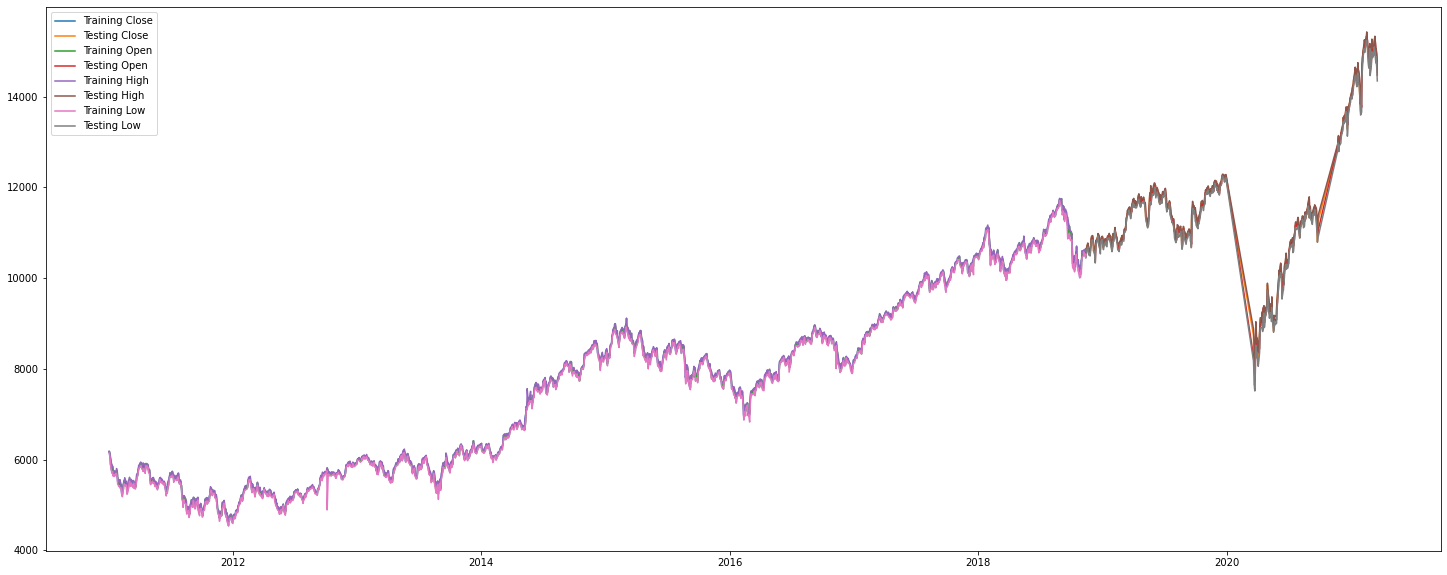

In [31]:
plt.figure(figsize=(25,10))
plt.plot(train['Close'] , label='Training Close')
plt.plot(test['Close'] , label='Testing Close')
plt.plot(train['Open'] , label='Training Open')
plt.plot(test['Open'] , label='Testing Open')
plt.plot(train['High'] , label='Training High')
plt.plot(test['High'] , label='Testing High')
plt.plot(train['Low'] , label='Training Low')
plt.plot(test['Low'] , label='Testing Low')

plt.legend()
plt.show()

In [32]:
X_train = []
y_train = []

for x in range(60,len(scaled_train)-1):
    temp = []
    for i in scaled_train[x-60 :x,]:
        temp.append(i[0] )
        temp.append(i[1])
        temp.append( i[2])
        temp.append(i[3])
        
    X_train.append(temp)
    
    y_train.append(scaled_train[x+1][3])

In [33]:
X_train = np.array(X_train)
y_train = np.array(y_train)

In [34]:
X_train[1] , y_train[0]

(array([0.22636669, 0.22752035, 0.21964607, 0.22269713, 0.22200213,
        0.22200213, 0.21102122, 0.21344671, 0.21722751, 0.21849933,
        0.20545427, 0.20906132, 0.20664967, 0.20947139, 0.18617516,
        0.18909414, 0.1886354 , 0.18946247, 0.16634697, 0.16939104,
        0.17009994, 0.1804762 , 0.16040477, 0.1681748 , 0.17456176,
        0.18486858, 0.1622256 , 0.18334652, 0.18160903, 0.18258202,
        0.16575623, 0.16786897, 0.1678968 , 0.17923213, 0.15226634,
        0.15433741, 0.15353817, 0.16011978, 0.15011186, 0.15436524,
        0.15822938, 0.16489441, 0.15665872, 0.16399784, 0.16584656,
        0.16727822, 0.1554494 , 0.15941087, 0.15453899, 0.16474849,
        0.15155051, 0.16226734, 0.15954987, 0.16309434, 0.15711047,
        0.16016844, 0.16303184, 0.16843888, 0.16034219, 0.16666664,
        0.16945354, 0.17477025, 0.1579653 , 0.15890354, 0.16417158,
        0.16428283, 0.14605313, 0.14735271, 0.14870103, 0.14875662,
        0.12723262, 0.13454398, 0.12625963, 0.13

In [35]:
model = SupervisedDBNRegression(hidden_layers_structure=[500],
                                    learning_rate_rbm=0.0001,
                                    learning_rate=0.0001,
                                    n_epochs_rbm=100,
                                    n_iter_backprop=200,
                                    batch_size=32,
                                    activation_function='relu')

In [36]:
model.fit(X_train , y_train)

[START] Pre-training step:
>> Epoch 1 finished 	RBM Reconstruction error 52.034834
>> Epoch 2 finished 	RBM Reconstruction error 48.766776
>> Epoch 3 finished 	RBM Reconstruction error 43.102236
>> Epoch 4 finished 	RBM Reconstruction error 33.705396
>> Epoch 5 finished 	RBM Reconstruction error 20.399058
>> Epoch 6 finished 	RBM Reconstruction error 7.424664
>> Epoch 7 finished 	RBM Reconstruction error 1.199987
>> Epoch 8 finished 	RBM Reconstruction error 0.633708
>> Epoch 9 finished 	RBM Reconstruction error 1.410417
>> Epoch 10 finished 	RBM Reconstruction error 1.928700
>> Epoch 11 finished 	RBM Reconstruction error 2.126192
>> Epoch 12 finished 	RBM Reconstruction error 2.208603
>> Epoch 13 finished 	RBM Reconstruction error 2.197952
>> Epoch 14 finished 	RBM Reconstruction error 2.274641
>> Epoch 15 finished 	RBM Reconstruction error 2.318997
>> Epoch 16 finished 	RBM Reconstruction error 2.311879
>> Epoch 17 finished 	RBM Reconstruction error 2.288886
>> Epoch 18 finished 	RBM

>> Epoch 53 finished 	ANN training loss 0.001875
>> Epoch 54 finished 	ANN training loss 0.001873
>> Epoch 55 finished 	ANN training loss 0.001873
>> Epoch 56 finished 	ANN training loss 0.001872
>> Epoch 57 finished 	ANN training loss 0.001871
>> Epoch 58 finished 	ANN training loss 0.001870
>> Epoch 59 finished 	ANN training loss 0.001868
>> Epoch 60 finished 	ANN training loss 0.001868
>> Epoch 61 finished 	ANN training loss 0.001867
>> Epoch 62 finished 	ANN training loss 0.001866
>> Epoch 63 finished 	ANN training loss 0.001865
>> Epoch 64 finished 	ANN training loss 0.001864
>> Epoch 65 finished 	ANN training loss 0.001863
>> Epoch 66 finished 	ANN training loss 0.001862
>> Epoch 67 finished 	ANN training loss 0.001861
>> Epoch 68 finished 	ANN training loss 0.001861
>> Epoch 69 finished 	ANN training loss 0.001860
>> Epoch 70 finished 	ANN training loss 0.001859
>> Epoch 71 finished 	ANN training loss 0.001858
>> Epoch 72 finished 	ANN training loss 0.001857
>> Epoch 73 finished

SupervisedDBNRegression()

In [37]:
test_scaled_close = scaler.transform(np.array(test['Close']).reshape(-1,1))
test_scaled_open = scaler.transform(np.array(test['Open']).reshape(-1,1))
test_scaled_high = scaler.transform(np.array(test['High']).reshape(-1,1))
test_scaled_low = scaler.transform(np.array(test['Low']).reshape(-1,1))

In [38]:
open_list = []
close_list = []
high_list = []
low_list = []
for i in range(len(test_scaled_open)):
    open_list.append(test_scaled_open[i])
    high_list.append(test_scaled_high[i])
    low_list.append(test_scaled_low[i])
    close_list.append( test_scaled_close[i])

In [39]:
open_arr = np.array(open_list).reshape(-1,1)
high_arr = np.array(high_list).reshape(-1,1)
low_arr = np.array(low_list).reshape(-1,1)
close_arr = np.array(close_list).reshape(-1,1)

In [40]:
scaled_data = pd.DataFrame(open_arr , columns=['Open'])
scaled_data['High'] = high_arr
scaled_data['Low'] = low_arr
scaled_data['Close'] = close_arr

In [41]:
scaled_test = np.array(scaled_data)

In [42]:
model.save('./models/ohlc10.pkl')

In [43]:
X_test = []
y_test = []

for x in range(60,len(scaled_test)-1):
    temp = []
    for i in scaled_test[x-60 :x,]:
        temp.append(i[0] )
        temp.append(i[1])
        temp.append( i[2])
        temp.append(i[3])
        
    X_test.append(temp)
    
    y_test.append(scaled_test[x+1][3])

In [44]:
X_test = np.array(X_test)
y_test = np.array(y_test)

In [45]:
preds = model.predict(X_test)

In [46]:
training_predictions = model.predict(X_train)

In [47]:
print('Mean Squared Error = {}'.format(mean_squared_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) , scaler.inverse_transform(training_predictions))))
print('Mean absolute Error = {}'.format(mean_absolute_error(scaler.inverse_transform(np.array(y_train).reshape(-1,1)) , scaler.inverse_transform(training_predictions))))

Mean Squared Error = 91346.00467450426
Mean absolute Error = 241.5837786240108


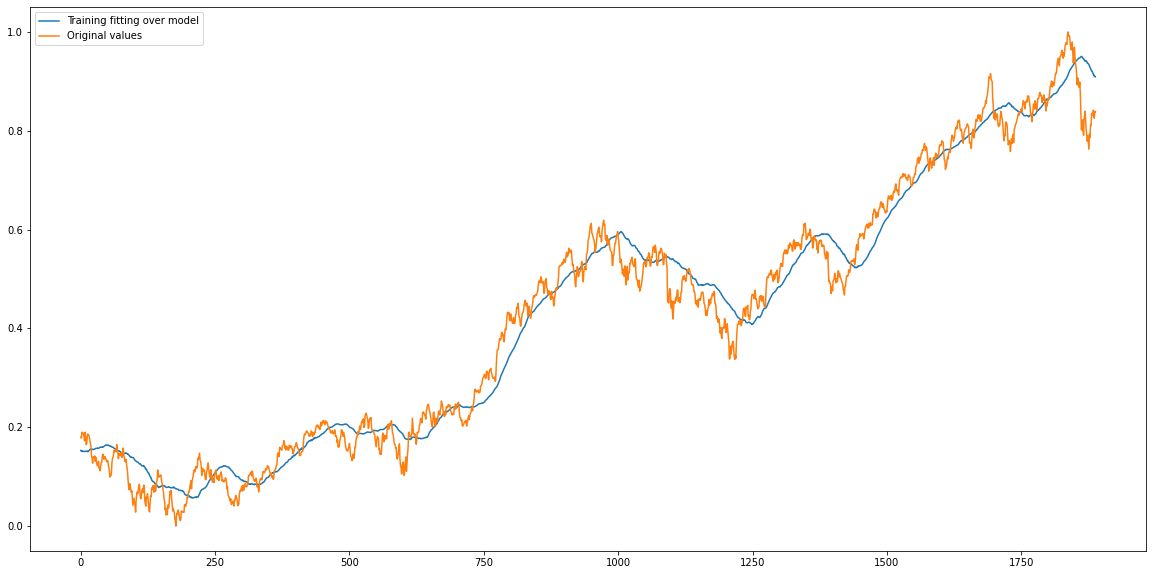

In [48]:
plt.figure(figsize=(20,10))
plt.plot(training_predictions , label='Training fitting over model')
plt.plot(y_train , label = 'Original values')
plt.legend()
plt.show()

In [49]:
print('Mean Squared Error = {}'.format(mean_squared_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) , scaler.inverse_transform(preds))))
print('Mean absolute Error = {}'.format(mean_absolute_error(scaler.inverse_transform(np.array(y_test).reshape(-1,1)) , scaler.inverse_transform(preds))))

Mean Squared Error = 1058947.414972915
Mean absolute Error = 763.4798999616762


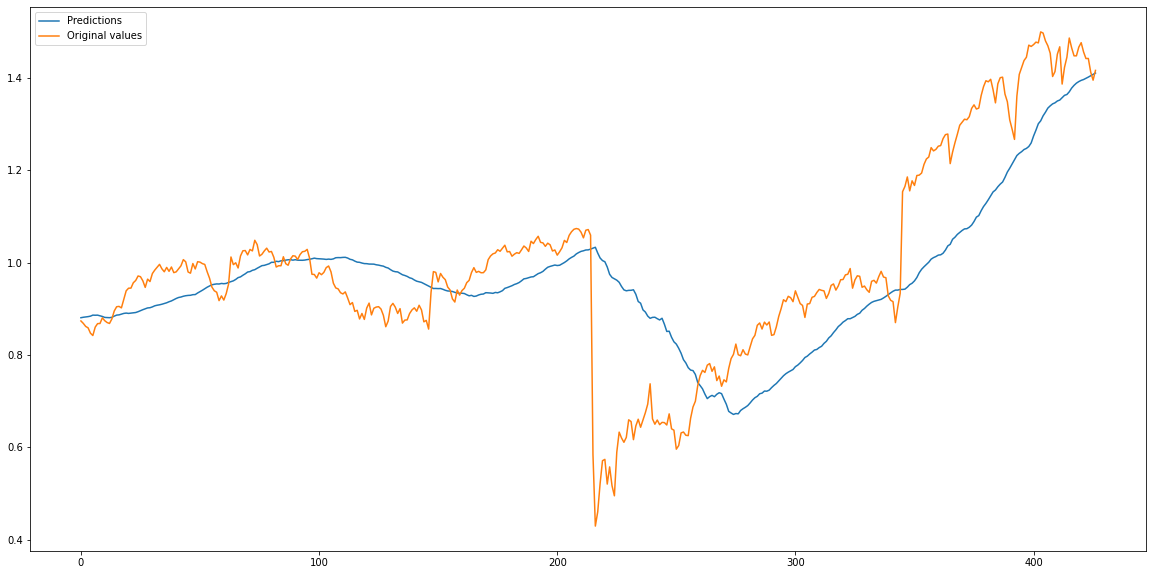

In [50]:
plt.figure(figsize=(20,10))
plt.plot(preds , label='Predictions')
plt.plot(y_test , label = 'Original values')
plt.legend()
plt.show()